In [3]:
%matplotlib inline

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
##from scipy.interpolate import spline

import logisticRegression as lr

In [5]:
#set index to passenger ID
#ignore unwanted columns when reading in 
trainingData = pd.read_csv('titanic-dataset-train.csv', index_col='passengerid', usecols=['passengerid', 'pclass', 'survived', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked'])
testingData = pd.read_csv('titanic-dataset-test.csv', index_col='passengerid', usecols=['passengerid', 'pclass', 'survived', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked'])

In [6]:
#useful pclass, sex, age, maybe sibsp?
#Not so useful - name, ticket, home.dest... 

#trainingData
#type(trainingData)

In [7]:
print('Total Passengers in Training set: ' + str(len(trainingData)))
print('Total Passengers in Testing set: ' + str(len(testingData)))

Total Passengers in Training set: 1000
Total Passengers in Testing set: 309


In [8]:
died = trainingData['survived'].count() - trainingData['survived'].sum()
survived = trainingData['survived'].sum()


    
print('Died:  ' + str(died))
print('Survived:  ' + str(survived))

print(str(died/len(trainingData)*100) + " percent death rate")

Died:  621
Survived:  379
62.1 percent death rate


In [9]:
trainingData.isnull().sum()

pclass        0
survived      0
sex           0
age         201
sibsp         0
parch         0
fare          0
embarked      2
dtype: int64

In [10]:
testingData.isnull().sum()

pclass       0
survived     0
sex          0
age         62
sibsp        0
parch        0
fare         1
embarked     0
dtype: int64

# Fixing Variables

In [11]:
def fixAges(passenger):
    
    age = passenger['age']
    pclass = passenger['pclass']
    
    if( np.isnan(age) and not (np.isnan(pclass)) ):
        #checking by class to assign an average age
        if(pclass == 1):
            return int(np.nanmean(trainingData['age'][trainingData['pclass'] == 1]))
        elif(pclass == 2):                
            return int(np.nanmean(trainingData['age'][trainingData['pclass'] == 2]))
        else:
            return int(np.nanmean(trainingData['age'][trainingData['pclass'] == 3]))
    else:
        return age

In [12]:
trainingData['age'] = trainingData.apply(fixAges, axis=1)
testingData['age'] = testingData.apply(fixAges, axis=1)

In [13]:
trainingData.isnull().sum()

pclass      0
survived    0
sex         0
age         0
sibsp       0
parch       0
fare        0
embarked    2
dtype: int64

In [14]:
testingData.isnull().sum()

pclass      0
survived    0
sex         0
age         0
sibsp       0
parch       0
fare        1
embarked    0
dtype: int64

In [16]:
trainingData = trainingData.dropna()
testingData = testingData.dropna()

In [15]:
print('Total Passengers in Training set: ' + str(len(trainingData)))
print('Total Passengers in Testing set: ' + str(len(testingData)))

Total Passengers in Training set: 1000
Total Passengers in Testing set: 309


In [16]:
# must convert categorical/string variables to dummy/numerical indicators

In [18]:
trainingData.loc

In [19]:
# converting sex column to 1 for male and 0 for female

#trainingData['Sex'] = trainingData['Sex'].apply(lambda sex: 1 if sex=='male' else 0)
#above recieves warning

trainingData.loc[:, 'sex'] = trainingData.loc[:, 'sex'].apply(lambda sex: 1 if sex=='male' else 0)
testingData.loc[:, 'sex'] = testingData.loc[:, 'sex'].apply(lambda sex: 1 if sex=='male' else 0)

In [20]:
#assign 0-2 for port of embarkation
#  0 for S (Southampton) - 1 for C (Cherbourg) - 2 for Q (Queenstown)

trainingData.loc[:, 'embarked'] = trainingData.loc[:, 'embarked'].apply(lambda port: 0 if port=='S' else 1 if port=='C' else 2)
testingData.loc[:, 'embarked'] = testingData.loc[:, 'embarked'].apply(lambda port: 0 if port=='S' else 1 if port=='C' else 2)

In [21]:
trainingData

,pclass,survived,sex,age,sibsp,parch,fare,embarked
passengerid,,,,,,,,
1,3,0,1,36.0,0,0,0.0000,0
2,2,0,1,21.0,0,0,73.5000,0
3,1,0,1,56.0,0,0,26.5500,0
4,2,0,0,29.0,0,0,21.0000,0
5,3,0,0,43.0,1,6,46.9000,0
...,...,...,...,...,...,...,...,...
996,3,0,1,30.0,0,0,7.2292,1
997,2,0,1,29.0,0,0,0.0000,0
998,3,1,1,32.0,0,0,7.9250,0


# Visualization

Text(0, 0.5, 'Raw Count')

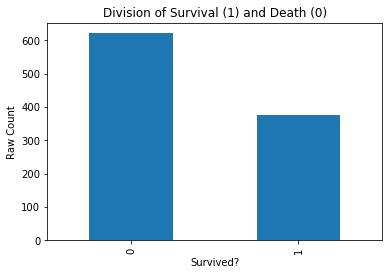

In [22]:
#Pay attention to this
#A 60% accurate model would be unimpressive
trainingData['survived'].value_counts().plot(kind = 'bar')
plt.title('Division of Survival (1) and Death (0)')

plt.xlabel('Survived?')
plt.ylabel('Raw Count')

Text(0.5, 0, 'Survived?')

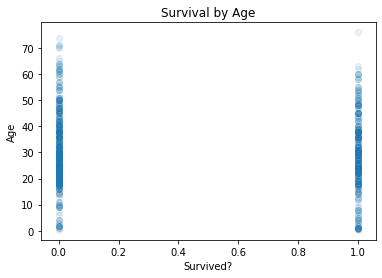

In [23]:
plt.scatter(trainingData['survived'], trainingData['age'], alpha= 0.1)
plt.title('Survival by Age')
plt.ylabel('Age')
plt.xlabel('Survived?')

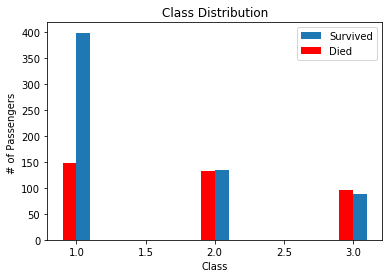

In [24]:
width = 0.1

plt.bar([1,2,3], trainingData['pclass'][trainingData['survived'] == 0].value_counts(), width=width, align='edge')
plt.bar([1,2,3], trainingData['pclass'][trainingData['survived'] == 1].value_counts(), width=-width, color='red', align='edge')

plt.title("Class Distribution")
plt.xlabel('Class')
plt.ylabel('# of Passengers ')
plt.legend(('Survived', 'Died'),loc='best') 

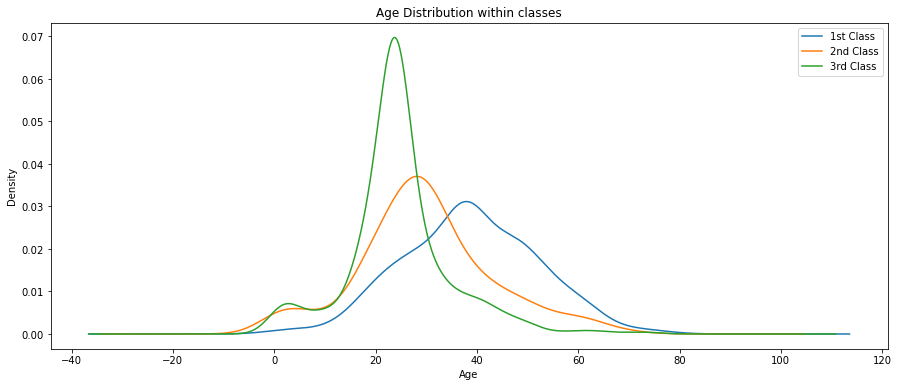

In [25]:
fig = plt.figure(figsize=(15,6))

#kernel density estimation to smoooooth
#older passengers more likely ot be in the more expensive classes
trainingData['age'][trainingData['pclass'] == 1].plot(kind ='kde') 
trainingData['age'][trainingData['pclass'] == 2].plot(kind ='kde')
trainingData['age'][trainingData['pclass'] == 3].plot(kind ='kde')

plt.xlabel("Age")    
plt.title("Age Distribution within classes")

plt.legend(('1st Class', '2nd Class','3rd Class'),loc='best') 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  


Text(0, 0.5, 'Raw Count')

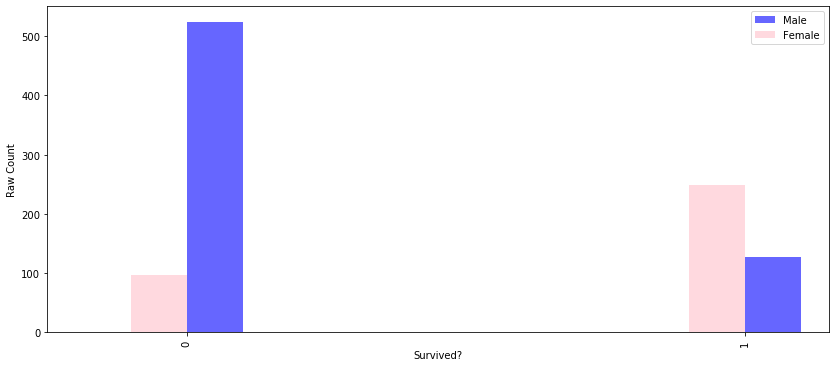

In [26]:
#Gender? 
fig = plt.figure(figsize=(14,6))

maleData = trainingData['survived'][trainingData['sex'] == 1].value_counts().sort_index()
femaleData = trainingData['survived'][trainingData['sex'] == 0].value_counts().sort_index()

maleData.plot('bar', color='blue', alpha=0.6, width=0.10, align='edge')
femaleData.plot('bar', color='pink', alpha=0.6, width=-0.10, align='edge')
plt.legend(('Male', 'Female'),loc='best') 
plt.xlabel('Survived?')
plt.ylabel('Raw Count')


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  if __name__ == '__main__':


(-0.5, 0.5)

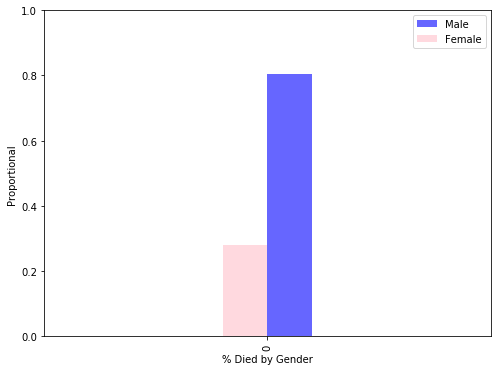

In [27]:
#Percentagewise
#~25% of makes survived and ~85% females 
fig = plt.figure(figsize=(8,6))

maleData = trainingData['survived'][trainingData['sex'] == 1].value_counts().sort_index()
femaleData = trainingData['survived'][trainingData['sex'] == 0].value_counts().sort_index()

(maleData/maleData.sum()).plot('bar', color='blue', alpha=0.6, width=0.10, align='edge')
(femaleData/femaleData.sum()).plot('bar', color='pink', alpha=0.6, width=-0.10, align='edge')

plt.legend(('Male', 'Female'),loc='best') 
plt.xlabel('% Died by Gender')
plt.ylabel('Proportional')
plt.ylim(0.0,1.0)
plt.xlim(-0.5, 0.5)

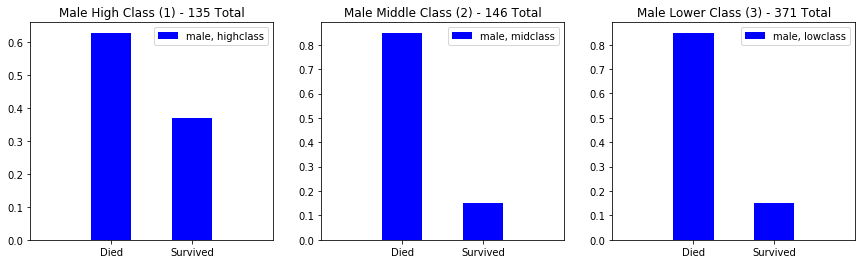

In [28]:
#What about class by gender
fig = plt.figure(figsize=(20,4))

ax0=fig.add_subplot(141)
male_class1 = trainingData['survived'][trainingData['sex'] == 1][trainingData['pclass'] == 1].value_counts()
(male_class1/male_class1.sum()).plot(kind='bar', label='male, highclass', color='blue')
ax0.axes.set_xticklabels(["Died", "Survived"], rotation=0)
ax0.set_xlim(-1, 2)
plt.title("Male High Class (1) - " + str(male_class1.sum()) + " Total") 
plt.legend()

ax1=fig.add_subplot(142)
male_class2 = trainingData['survived'][trainingData['sex'] == 1][trainingData['pclass'] == 2].value_counts()
(male_class2/male_class2.sum()).plot(kind='bar', label='male, midclass', color='blue')
ax1.axes.set_xticklabels(["Died", "Survived"], rotation=0)
ax1.set_xlim(-1, 2)
plt.title("Male Middle Class (2) - " + str(male_class2.sum()) + " Total") 
plt.legend()

ax1=fig.add_subplot(143)
male_class3 = trainingData['survived'][trainingData['sex'] == 1][trainingData['pclass'] == 3].value_counts()
(male_class3/male_class3.sum()).plot(kind='bar', label='male, lowclass', color='blue')
ax1.axes.set_xticklabels(["Died", "Survived"], rotation=0)
ax1.set_xlim(-1, 2)
plt.title("Male Lower Class (3) - " + str(male_class3.sum()) + " Total") 
plt.legend()

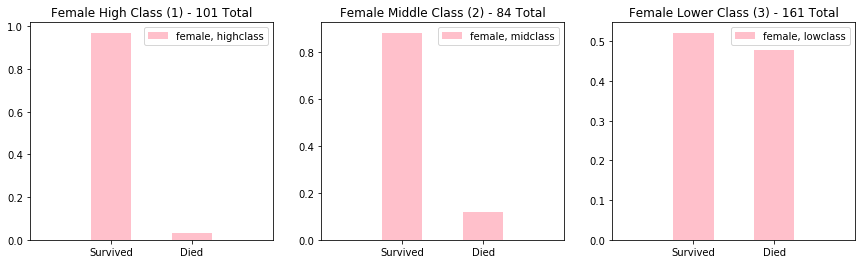

In [29]:
fig = plt.figure(figsize=(20,4))

ax0=fig.add_subplot(141)
female_class1 = trainingData['survived'][trainingData['sex'] == 0][trainingData['pclass'] == 1].value_counts()
(female_class1/female_class1.sum()).plot(kind='bar', label='female, highclass', color='pink')
ax0.axes.set_xticklabels(["Survived", "Died"], rotation=0)
ax0.set_xlim(-1, 2)
plt.title("Female High Class (1) - " + str(female_class1.sum()) + " Total") 
plt.legend()

ax1=fig.add_subplot(142)
female_class2 = trainingData['survived'][trainingData['sex'] == 0][trainingData['pclass'] == 2].value_counts()
(female_class2/female_class2.sum()).plot(kind='bar', label='female, midclass', color='pink')
ax1.axes.set_xticklabels(["Survived", "Died"], rotation=0)
ax1.set_xlim(-1, 2)
plt.title("Female Middle Class (2) - " + str(female_class2.sum()) + " Total") 
plt.legend()

ax1=fig.add_subplot(143)
female_class3 = trainingData['survived'][trainingData['sex'] == 0][trainingData['pclass'] == 3].value_counts()
(female_class3/female_class3.sum()).plot(kind='bar', label='female, lowclass', color='pink')
ax1.axes.set_xticklabels(["Survived", "Died"], rotation=0)
ax1.set_xlim(-1, 2)
plt.title("Female Lower Class (3) - " + str(female_class3.sum()) + " Total") 
plt.legend()

Text(0.5, 0, 'Passenger Class')

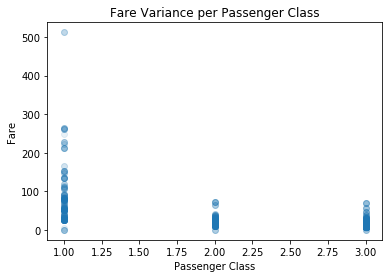

In [30]:
#Are fare and class independent?
plt.scatter(trainingData['pclass'], trainingData['fare'], alpha= 0.1)
plt.title('Fare Variance per Passenger Class')
plt.ylabel('Fare')
plt.xlabel('Passenger Class')

Text(0.5, 0, 'Survived')

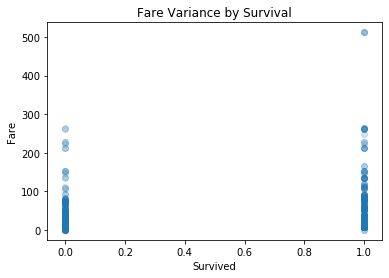

In [31]:
#Did the fare paid effect survival
plt.scatter(trainingData['survived'], trainingData['fare'], alpha= 0.2)
plt.title('Fare Variance by Survival')
plt.ylabel('Fare')
plt.xlabel('Survived')

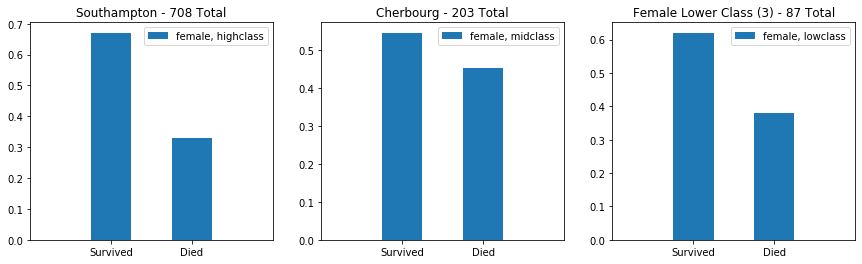

In [32]:
#Did port of embarkation effect survival rate
fig = plt.figure(figsize=(20,4))

ax0=fig.add_subplot(141)
embarked_S = trainingData['survived'][trainingData['embarked'] == 0].value_counts()
(embarked_S/embarked_S.sum()).plot(kind='bar', label='female, highclass')
ax0.axes.set_xticklabels(["Survived", "Died"], rotation=0)
ax0.set_xlim(-1, 2)
plt.title("Southampton - " + str(embarked_S.sum()) + " Total") 
plt.legend()

ax1=fig.add_subplot(142)
embarked_C = trainingData['survived'][trainingData['embarked'] == 1].value_counts()
(embarked_C/embarked_C.sum()).plot(kind='bar', label='female, midclass')
ax1.axes.set_xticklabels(["Survived", "Died"], rotation=0)
ax1.set_xlim(-1, 2)
plt.title("Cherbourg - " + str(embarked_C.sum()) + " Total") 
plt.legend()

ax1=fig.add_subplot(143)
embarked_Q = trainingData['survived'][trainingData['embarked'] == 2].value_counts()
(embarked_Q/embarked_Q.sum()).plot(kind='bar', label='female, lowclass')
ax1.axes.set_xticklabels(["Survived", "Died"], rotation=0)
ax1.set_xlim(-1, 2)
plt.title("Female Lower Class (3) - " + str(embarked_Q.sum()) + " Total") 
plt.legend()

# Implementing Logistic Regression

In [33]:
#features/x's - 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked'
someFeatures = np.array(trainingData.loc[:, ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']])
someTestFeatures = np.array(testingData.loc[:, ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']])

#adding column of ones 
constantCol = np.ones((len(someFeatures),1))
constantTestCol = np.ones((len(someTestFeatures), 1))
features = np.hstack((someFeatures, constantCol))
testFeatures = np.hstack((someTestFeatures, constantTestCol))


#parameters/thetas - 7 features + 1 intercept = 8
thetas = np.zeros((8,1))

#classes/y's - 'survived'
labels = np.array(trainingData.loc[:,['survived']], ndmin=2)

testLabels = np.array(testingData.loc[:,['survived']], ndmin=2)


print("Training Set Shape: " + str(features.shape))
print("Cross Validation Set Shape: " + str(testFeatures.shape))

print("Theta Set Shape: " + str(thetas.shape))

print("Training Labels Set Shape: " + str(labels.shape))
print("Cross Validation Labels Set Shape: " + str(testLabels.shape))

Training Set Shape: (998, 8)
Cross Validation Set Shape: (308, 8)
Theta Set Shape: (8, 1)
Training Labels Set Shape: (998, 1)
Cross Validation Labels Set Shape: (308, 1)


In [34]:
#all being stopped at 500000 iterations and thetas starting at 0.0
#alpha = 0.05  # got to 0.7402 - w/ wild fluctuations
#alpha = 0.01  # got to 0.7695
#alpha = 0.007 # got to 0.8084
alpha = 0.005 # got to 0.8247
#alpha = 0.003 # got to 0.8117
#alpha = 0.001 # got to 0.8019
#alpha = 1e-4  # got to 0.7987
#alpha = 1e-5  # got to 0.6883

minCostDif = 1e-10
maxIterations = 500000
lr.gradientDescent(features, thetas, labels, alpha, minCostDif, maxIterations, testFeatures, testLabels)

Accuracy at 5000 Iterations: 0.7272727272727273
Accuracy at 10000 Iterations: 0.7857142857142857
Accuracy at 15000 Iterations: 0.8084415584415584
Accuracy at 20000 Iterations: 0.8116883116883117
Accuracy at 25000 Iterations: 0.8214285714285714
Accuracy at 30000 Iterations: 0.827922077922078
Accuracy at 35000 Iterations: 0.8214285714285714
Accuracy at 40000 Iterations: 0.8214285714285714
Accuracy at 45000 Iterations: 0.8214285714285714
Accuracy at 50000 Iterations: 0.8214285714285714
Accuracy at 55000 Iterations: 0.8214285714285714
Accuracy at 60000 Iterations: 0.8214285714285714
Accuracy at 65000 Iterations: 0.8181818181818182
Accuracy at 70000 Iterations: 0.8181818181818182
Accuracy at 75000 Iterations: 0.8181818181818182
Accuracy at 80000 Iterations: 0.8181818181818182
Accuracy at 85000 Iterations: 0.8181818181818182
Accuracy at 90000 Iterations: 0.8181818181818182
Accuracy at 95000 Iterations: 0.8181818181818182
Accuracy at 100000 Iterations: 0.8214285714285714
Accuracy at 105000 It

array([[-1.08208129e+00],
       [-2.63656693e+00],
       [-4.73582124e-02],
       [-3.56013400e-01],
       [-4.94966802e-02],
       [-1.80775987e-03],
       [ 2.97862578e-01],
       [ 4.57615573e+00]])

In [35]:
#fix labels for sklearn

labels_sk = labels.flatten()
testLabels_sk = testLabels.flatten()

print(labels_sk.shape)
print(testLabels_sk.shape)

(998,)
(308,)


In [36]:
from sklearn.linear_model import LogisticRegression

logR = LogisticRegression()

logR.fit(features, labels_sk)

labelsPred = logR.predict(testFeatures)

print(logR)
print("accuracy:", np.sum(testLabels_sk == labelsPred) * 1. / len(testLabels_sk))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
accuracy: 0.8051948051948052


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [37]:
# C is the inverse of the regularization constant
# Can turn it off by making it large - default is 1.0

from sklearn.linear_model import LogisticRegression

logR = LogisticRegression(C=1e10)

logR.fit(features, labels_sk)

labelsPred = logR.predict(testFeatures)

print(logR)
print("accuracy:", np.sum(testLabels_sk == labelsPred) * 1. / len(testLabels_sk))

LogisticRegression(C=10000000000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
accuracy: 0.8116883116883117


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [38]:
# automatically assigns weights to the coeffiecient
# "balanced" based on inverse proportion to the class frequencies - could see this being more useful in multiclass

from sklearn.linear_model import LogisticRegression

logR = LogisticRegression(C=1e10, class_weight="balanced")

logR.fit(features, labels_sk)

labelsPred = logR.predict(testFeatures)

print(logR)
print("accuracy:", np.sum(testLabels_sk == labelsPred) * 1. / len(testLabels_sk))

LogisticRegression(C=10000000000.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
accuracy: 0.7857142857142857


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

logR = LogisticRegression(C=1e10)

#Cross validation
X1, X2, y1, y2 = train_test_split(features, labels_sk, test_size=0.5)

y1_pred = logR.fit(X1, y1).predict(X2)
y2_pred = logR.fit(X2, y2).predict(X1)

print(np.mean([metrics.precision_score(y1, y1_pred), metrics.precision_score(y2, y2_pred)]))

0.32623663101604283


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

[0.7295657089651504, 0.7412622396320581, 0.7560611984339317, 0.7489151445059041, 0.748575338591062, 0.7461144567426771, 0.7505554743427241, 0.7537261102012291, 0.7440153290677392, 0.7460537949648658, 0.7558738162440797, 0.7490802706308415, 0.751568293383561, 0.7461894931071132, 0.7519450456024397, 0.7600404646548337, 0.7537419076260665, 0.7561864257217107, 0.7510576246508909]


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

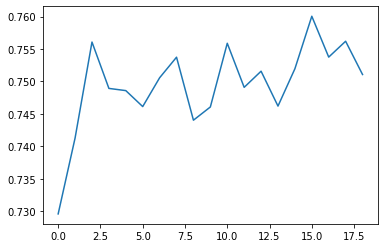

In [44]:
from sklearn.model_selection import cross_val_score

cvVals = np.linspace(2,20,19, dtype=int)

precision = []
for cv in cvVals:
    precision.append(np.mean(cross_val_score(LogisticRegression(C=1e10), features, labels_sk, cv=cv, scoring='precision')))

print(precision)
plt.plot(precision)

In [45]:
#Trying an SVM
from sklearn.svm import SVC # "Support Vector Classifier"
svc = SVC(kernel='sigmoid')
svc.fit(features, labels_sk)

labelsPred = svc.predict(testFeatures)
print("accuracy:", np.sum(testLabels_sk == labelsPred) * 1. / len(testLabels_sk))

accuracy: 0.6071428571428571


/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [46]:
#Trying an SVM
from sklearn.svm import SVC # "Support Vector Classifier"
svc = SVC(kernel='linear')
svc.fit(features, labels_sk)

labelsPred = svc.predict(testFeatures)
print("accuracy:", np.sum(testLabels_sk == labelsPred) * 1. / len(testLabels_sk))

accuracy: 0.7954545454545454
